In [8]:
import pandas as pd
import numpy as np
import pyro 

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def plot_from_nodes(
    nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None, bins=20
):
    """
    The plot_from_nodes function takes a dictionary of nodes, processes their values, optionally filters the data,
     and plots histograms for specified nodes. The function then returns the processed DataFrame.
     Parameters:
     - nodes: Dictionary of nodes containing data.
     - filters: Optional dictionary to filter the data based on specified conditions.
     - nodes_to_plot: Optional list of specific nodes to plot. If not provided, plots all nodes.
     - bins: Number of bins for the histograms (default is 20).

     Returns:
     - DataFrame of the processed values.
    """

    values = {
        key: nodes[key]["value"].float().detach().cpu().numpy()
        for key in nodes.keys()
        if nodes[key]["name"] != "samples"
    }

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=bins, alpha=0.7, color="blue", density=True)
        plt.title(f"{key}, mean: {valuesDF[key].mean()}")
        plt.xlabel("value")
        plt.ylabel("frequency")
        sns.despine()
        plt.show()

    return valuesDF


In [22]:
def normalize_posterior(posterior: torch.Tensor, k: int = 1000) -> torch.Tensor:

    hist = torch.histc(posterior, bins=k)
    return hist / hist.sum()


def weight(posterior: List[float], base=2) -> float:

    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(x, 1, 1)
    entropy_uniform = entropy(uniform, base=base)
    entropy_posterior = entropy(posterior, base=base)
    return 1 - entropy_posterior / entropy_uniform



In [33]:
# def expected_value(prior: List[float], posterior: List[float], k: int) -> float:
#     exp_val = 0
#     for i in range(1, k + 1):
    
#         p_si_prior = prior[i % len(prior)]  
        
   
#         val_e_i_prior = weight(prior, posterior)  
        
       
#         exp_val += p_si_prior * val_e_i_prior

#     return exp_val



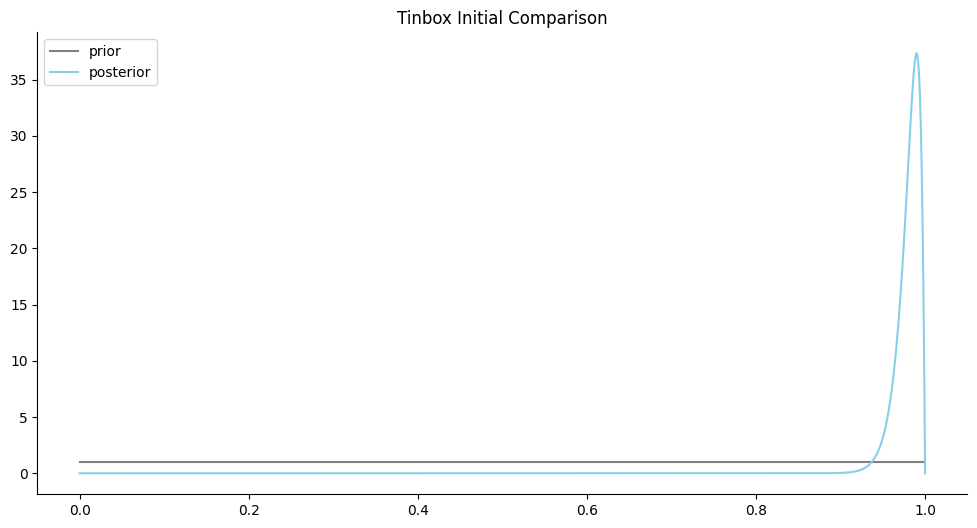

In [32]:
x = np.linspace(0, 1, 1000)
prior = beta.pdf(x, 1, 1)
posterior = beta.pdf(x, 100, 2)

fingers_if_father = beta.pdf(x, 1000, 2)
posterior_up_unst = (posterior * fingers_if_father) 
posterior_up_stnd = posterior_up_unst / posterior_up_unst.sum()

plt.figure(figsize=(12, 6))
plt.plot(x, prior, label="prior", color="grey")
plt.plot(x, posterior, label="posterior", color="skyblue")
# plt.plot(x, posterior_up_unst, label="posterior_up", color="orangered")
plt.title("Tinbox Initial Comparison")
plt.legend()
sns.despine()
plt.show()

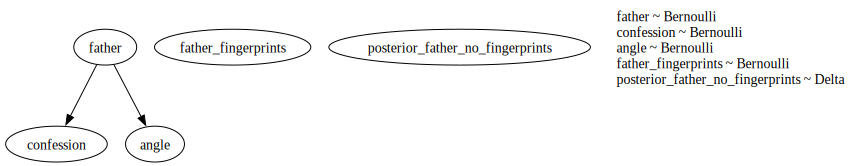

In [6]:
import pyro
import pyro.distributions as dist
import torch

def simplified_tinbox_model():
    pr_father = 0.5  
    pr_confession_if_father = 0.8
    pr_confession_if_no_father = 0.2
    pr_angle_if_father = 0.1
    pr_angle_if_no_father = 0.9
    pr_father_fingerprints_if_father = 0.7

    father = pyro.sample("father", dist.Bernoulli(pr_father))
    
    confession_prob = torch.where(father == 1, pr_confession_if_father, pr_confession_if_no_father)
    confession = pyro.sample("confession", dist.Bernoulli(confession_prob))
    
    angle_prob = torch.where(father == 1, pr_angle_if_father, pr_angle_if_no_father)
    angle = pyro.sample("angle", dist.Bernoulli(angle_prob))
    
    father_fingerprints = pyro.sample("father_fingerprints", dist.Bernoulli(pr_father_fingerprints_if_father))

    evidence_mask = (confession == 1) & (angle == 1)

    posterior_father_no_fingerprints = pyro.sample("posterior_father_no_fingerprints", 
        dist.Delta(torch.tensor(1.0 - father)) if evidence_mask & (father_fingerprints == 0) 
        else dist.Delta(torch.tensor(float("nan")))
    )

    return {
        'posterior_father_no_fingerprints': posterior_father_no_fingerprints,
        'father_fingerprints': father_fingerprints
    }

# Render the model to visualize the DAG with only the selected variables
pyro.render_model(simplified_tinbox_model, model_args=(), render_distributions=True)


Graphviz


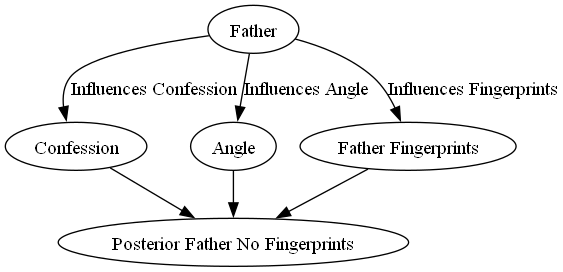

In [12]:
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph(comment="Murder Case DAG")

dot.node('F', 'Father')
dot.node('C', 'Confession')
dot.node('A', 'Angle')
dot.node('FF', 'Father Fingerprints')
dot.node('P', 'Posterior Father No Fingerprints')

dot.edge('F', 'C', label="Influences Confession")
dot.edge('F', 'A', label="Influences Angle")
dot.edge('F', 'FF', label="Influences Fingerprints")
dot.edge('C', 'P')
dot.edge('A', 'P')
dot.edge('FF', 'P')


png_path = dot.render('murder_case_dag', format='png') # saving the PNG

display(Image(png_path))


Dagitty


In [ ]:
# library(dagitty)
# library(ggplot2)

# dag <- dagitty('
#     dag {
#         Father [label="Father"]
#         Confession [label="Confession"]
#         Angle [label="Angle"]
#         FatherFingerprints [label="Father Fingerprints"]
#         PosteriorFatherNoFingerprints [label="Posterior Father No Fingerprints"]
#         Father -> Confession
#         Father -> Angle
#         Father -> FatherFingerprints
#         Confession -> PosteriorFatherNoFingerprints
#         Angle -> PosteriorFatherNoFingerprints
#         FatherFingerprints -> PosteriorFatherNoFingerprints
#     }
# ')

# plot(dag)

# p <- plot(dag)
# ggsave("dag_plot_no_abbreviations.png", plot = p)


![](tinbox_dagitty_plot.png){ fig-align="center" width="60%"}